# (14) Inference on the Least Square fitting procedure for $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ of each generation.

...

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
conc_sep_all_lins = [];
for i in 1:length(fluor_sep_all_lins)
    num_i = fluor_sep_all_lins[i]./fpm;
    conc_i = [num_i[y] ./ vol_sep_all_lins[i][y] for y in 1:length(vol_sep_all_lins[i])];
    push!(num_sep_all_lins,num_i);
    push!(conc_sep_all_lins,conc_i);
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

Now let's plot the first 10 generations of the first lineage of 37$^{\circ}C$ Tanouchi data.

In [4]:
using Plots, Statistics, StatsBase, Distances, Distributions, GpABC, LaTeXStrings, LinearAlgebra; pyplot();

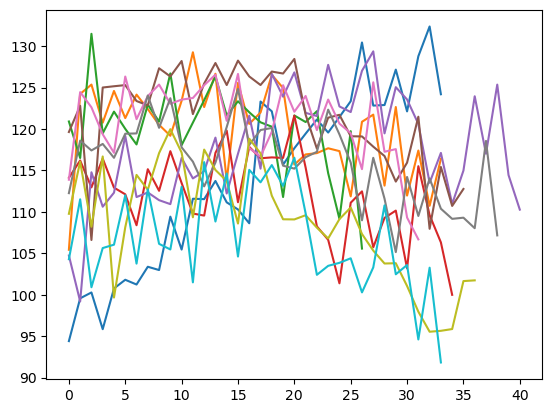

In [619]:
e_gen = 10;
conc_gens = deepcopy(conc_sep_all_lins[e_gen]);
fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(conc_gens[i])
end
PyPlot.show()

## Calculate $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ from Lsq on the mean for each generation

In [620]:
using LsqFit;

In [621]:
LinRange(1,length(conc_gens[1]), length(conc_gens[1]))

34-element LinRange{Float64}:
 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,…,28.0,29.0,30.0,31.0,32.0,33.0,34.0

In [622]:
comb_pars = [];
for i in 1:length(v0_n0_th[e_gen])
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]-1))/(10 .^ab[2]*th))*(exp.((10 .^ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [-1.0, -1.0];
    c_data = conc_gens[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)));

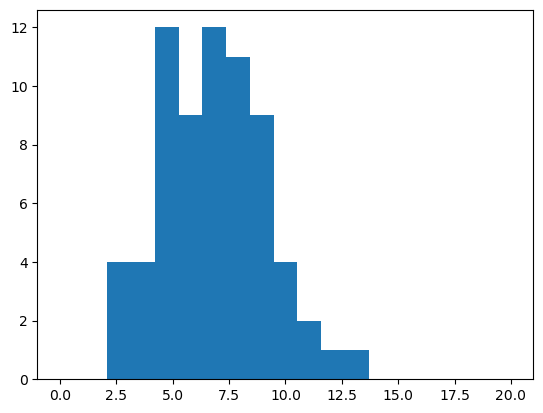

In [623]:
PyPlot.hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20));

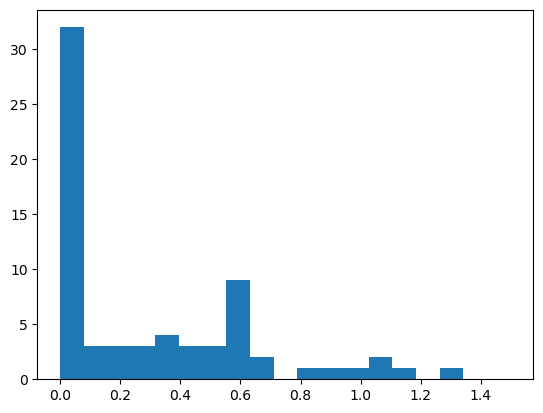

In [624]:
PyPlot.hist(comb_pars[:,2], bins = LinRange(0.0, 1.5, 20));

**Interesting that this same peak at zero (seen in all the experimental data) is recovered in the expt SSA with large burst sizes. Rather than fitting choosing $\alpha_0 \beta_0$ and $\alpha_1 +\beta_1$ to the means of these distributions we would undergo another ABC procedure to match the distributions of the experimental LSQ fitting to the SSA. This could allow for full determination of parameters in the stochastic model. Distance function would be the product of the HD of each histogram compared to the experimental data.**

**This possibly makes sense since if the burst size is volume dependent only some experimental runs will be subjegated to the stochasticity of the burst size unlike the more deterministic increase in molecule over every trajectory seen when the transcription rate is volume dependent.**

**Highly indicative of burst size dependency on volume.**

**However, even if this doesn't work out I can always use the predictions since (as we see below) the Lsq fitting procedure finds the parameters relatively well.**

Let's have a look at the average values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$.

In [625]:
av_ab_0 = mean(comb_pars[:,1]); av_ab_1 = mean(comb_pars[:,2]);
print(av_ab_0, "\t", av_ab_1)

6.841661941064748	0.28539303176624536

In [626]:
fcp = filter(x->x>0.01, comb_pars[:,2])
av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(fcp)/length(fcp);
print(av_ab_0, "\t", av_ab_1, "\t")

6.841661941064748	0.5182135524375201	

**Median of the filtered values (removing zeros on second histogram) seems to give the best parameter values from the artificial data below. Generally for the experimental data we find $\alpha_1+\beta_1 \approx 0.5$**

In [627]:
fcp = filter(x->x>0.01, comb_pars[:,2])
av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(fcp)
print(av_ab_0, "\t", av_ab_1, "\t")

6.9167733779681635	0.49785587207151294	

In [707]:
av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(comb_pars[:,2])
print(av_ab_0, "\t", av_ab_1, "\t")

3.4212779054960865	1.0889881247363613	

Let's also have a check of the individual mean concentrations compared to the trajectory they are derived from.

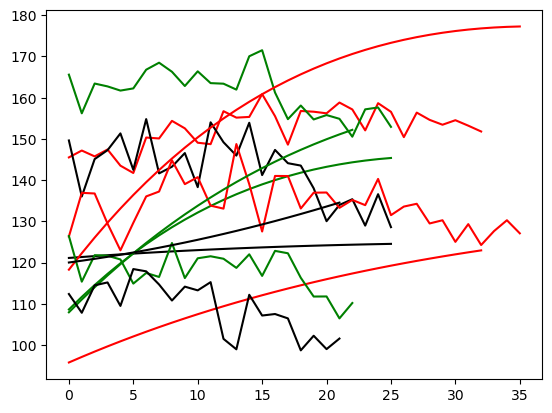

In [708]:
avg_traj = [];
for i in 1:10
    v0 = v0_n0_th[e_gen][i][1]; n0 = v0_n0_th[e_gen][i][2]; th = v0_n0_th[e_gen][i][3];
    c_0 = n0/v0; #ab = [av_ab_0, av_ab_1];
    ab = comb_pars[i,:];
    traj = [((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t) for t in 1:length(conc_gens[i])];
    push!(avg_traj,traj)
end

colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:6#length(conc_gens)
    ax.plot(conc_gens[i], color = colors[i])
    ax.plot(avg_traj[i], color = colors[i])
end
PyPlot.show()

## Artificial data: mean burst size dependence on volume.

Now let's do the same for some artificial data.

In [653]:
true_par = [0.1,1E-6,0.5,1.0];

In [654]:
lineage_data = conc_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_c, ssa[2][:]);
    end
    return vcat(SSA_data_c)# return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [655]:
expt_ssa_conc = Single_lin(conc_gens, true_par, v0_n0_th[1]);

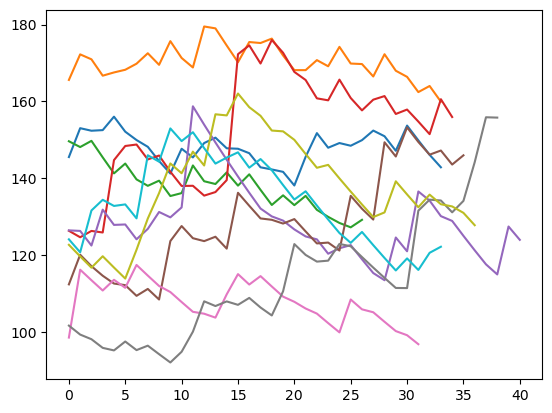

In [656]:
conc_gens_art = deepcopy(expt_ssa_conc);
fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(conc_gens_art[i])
end
PyPlot.show()

In [657]:
LinRange(1,length(expt_ssa_conc[1]), length(expt_ssa_conc[1]))

34-element LinRange{Float64}:
 1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,…,28.0,29.0,30.0,31.0,32.0,33.0,34.0

In [658]:
comb_pars = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]-1))/(10 .^ab[2]*th))*(exp.((10 .^ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [5.0, 1.0];
    c_data = expt_ssa_conc[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)));

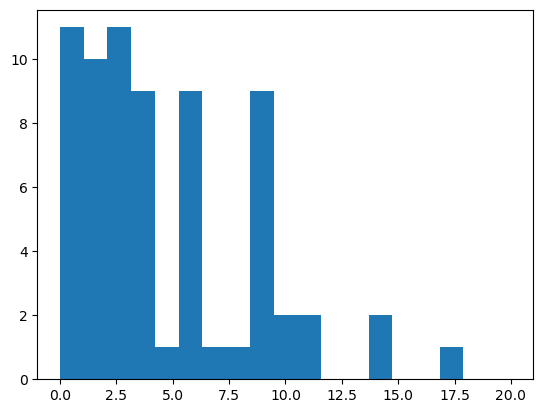

In [659]:
PyPlot.hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20));

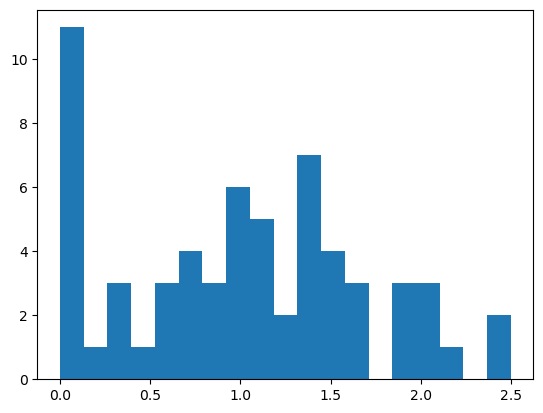

In [660]:
PyPlot.hist(comb_pars[:,2], bins = LinRange(0.0, 2.5, 20));

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [661]:
av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(comb_pars[:,2])/length(comb_pars[:,2]);
print("Mean Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")
print("True values: \t ", 10^true_par[1]*10^true_par[3], "\t", true_par[2]+true_par[4], "\n")

Mean Lsq values: 4.690259650568509	1.222232971581513
True values: 	 3.981071705534973	1.000001


Does filtering out the zeros make it better? No... (see below).

In [662]:
cp2 = filter(x -> x > 0.01, comb_pars[:,2]);

av_ab_0 = sum(comb_pars[:,1])/length(comb_pars[:,1]); av_ab_1 = sum(cp2)/length(cp2);
print("Mean Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")
print("True values: \t ", 10^true_par[1]*10^true_par[3], "\t", true_par[2]+true_par[4], "\n")

Mean Lsq values: 4.690259650568509	1.4055679173180466
True values: 	 3.981071705534973	1.000001


What about the median?

In [663]:
av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(comb_pars[:,2]);
print("Median Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")
print("True values: \t   ", 10^true_par[1]*10^true_par[3], "\t", true_par[2]+true_par[4], "\n")

Median Lsq values: 3.421277895480592	1.0889881247644513
True values: 	   3.981071705534973	1.000001


Median of the filtered values? Pretty good here actually.

In [664]:
cp2 = filter(x -> x > 0.01, comb_pars[:,2]);

av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(cp2);
print("Mean Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")
print("True values: \t ", 10^true_par[1]*10^true_par[3], "\t", true_par[2]+true_par[4], "\n")

Mean Lsq values: 3.421277895480592	1.2935179877759468
True values: 	 3.981071705534973	1.000001


Original predicted parameters are not bad. Let's have a look at the fit on each generation again.

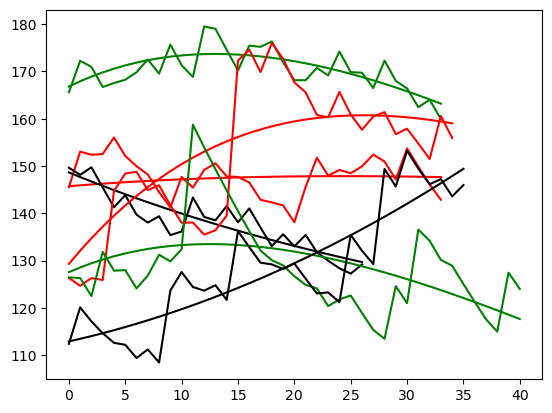

In [665]:
avg_traj = [];
for i in 1:10
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; #ab = [av_ab_0, av_ab_1];
    ab = comb_pars[i,:];
    traj = [((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t) for t in 1:length(conc_gens_art[i])];
    push!(avg_traj,traj)
end

#print(avg_traj[1]);
colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:6#length(conc_gens)
    ax.plot(conc_gens_art[i], color = colors[i])
    ax.plot(avg_traj[i], color = colors[i])
end
PyPlot.show()

## Let's do the same for a volume dependent transcription rate

In [666]:
true_par_2 = [0.1,1.0,0.5,1E-6];

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [667]:
expt_ssa_conc_2 = Single_lin(conc_gens, true_par_2, v0_n0_th[1]);

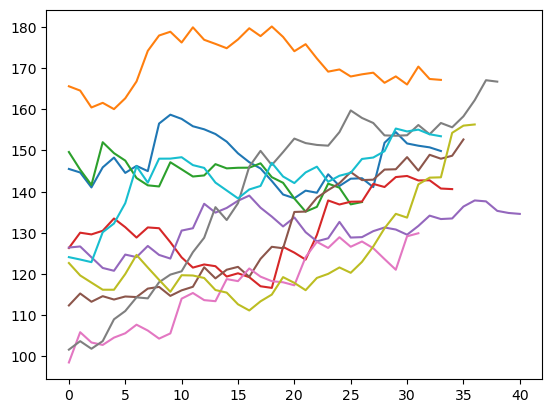

In [668]:
conc_gens_art_2 = deepcopy(expt_ssa_conc_2);
fig, ax = PyPlot.subplots(1,1);
for i in 1:10#length(conc_gens)
    ax.plot(conc_gens_art_2[i])
end
PyPlot.show()

In [669]:
comb_pars_2 = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10 .^ab[1]*v0^(10 .^ab[2]-1))/(10 .^ab[2]*th))*(exp.((10 .^ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [5.0, 1.0];
    c_data = expt_ssa_conc_2[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars_2,fit)
end
comb_pars_2 = convert(Array{Float64,2},transpose(hcat(comb_pars_2...)));

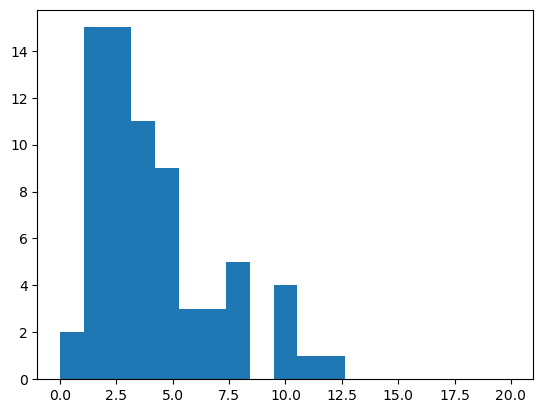

In [670]:
PyPlot.hist(comb_pars_2[:,1], bins = LinRange(0.0, 20, 20));

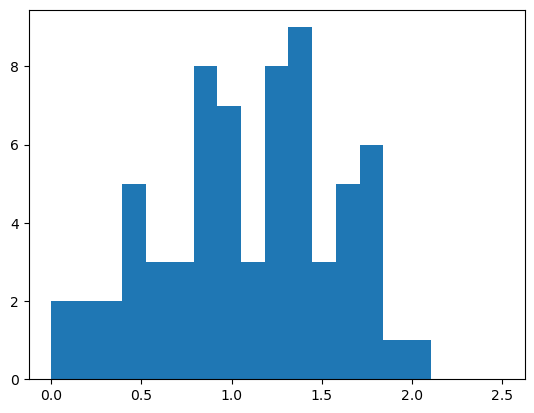

In [671]:
PyPlot.hist(comb_pars_2[:,2], bins = LinRange(0.0, 2.5, 20));

In [672]:
comb_pars_2[:,2];

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [673]:
av_ab_0_2 = sum(comb_pars_2[:,1])/length(comb_pars_2[:,1]); av_ab_1_2 = sum(comb_pars_2[:,2])/length(comb_pars_2[:,2]);
print("Mean Lsq values: ", av_ab_0_2, "\t", av_ab_1_2, "\n")
print("True values: \t ", 10^true_par_2[1]*10^true_par_2[3], "\t", true_par_2[2]+true_par_2[4], "\n")

Mean Lsq values: 4.189038548990676	1.1181867206564406
True values: 	 3.981071705534973	1.000001


Not bad. Let's have a look at the fit on each generation again. But does taking the median make for better inference of $\alpha_1+\beta_1$?

In [674]:
av_ab_0_2 = median(comb_pars_2[:,1]); av_ab_1_2 = median(comb_pars_2[:,2]);
print("Median Lsq values: ", av_ab_0_2, "\t", av_ab_1_2, "\n")
print("True values: \t   ", 10^true_par_2[1]*10^true_par_2[3], "\t", true_par_2[2]+true_par_2[4], "\n")

Median Lsq values: 3.4010805986011	1.1250785948307733
True values: 	   3.981071705534973	1.000001


Again the median of the filtered values (again bang on).

In [675]:
cp22 = filter(x -> x > 0.01, comb_pars_2[:,2]);

av_ab_0_2 = median(comb_pars_2[:,1]); av_ab_1 = median(cp22);
print("Mean Lsq values: ", av_ab_0_2, "\t", av_ab_1_2, "\n")
print("True values: \t ", 10^true_par_2[1]*10^true_par_2[3], "\t", true_par_2[2]+true_par_2[4], "\n")

Mean Lsq values: 3.4010805986011	1.1250785948307733
True values: 	 3.981071705534973	1.000001


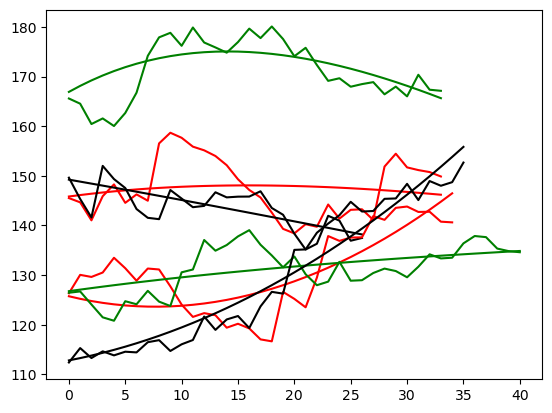

In [676]:
avg_traj_2 = [];
for i in 1:10
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; #ab = [av_ab_0, av_ab_1];
    ab = comb_pars_2[i,:];
    traj = [((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t) for t in 1:length(conc_gens_art[i])];
    push!(avg_traj_2,traj)
end

#print(avg_traj[1]);
colors = ["r","g","black","r","g","black","r","g","black"];
fig, ax = PyPlot.subplots(1,1);
for i in 1:6#length(conc_gens)
    ax.plot(conc_gens_art_2[i], color = colors[i])
    ax.plot(avg_traj_2[i], color = colors[i])
end
PyPlot.show()

# Inference on histograms of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$

Now let's set up the tools needed to perform the inference of the parameters as we did in notebook 5. In this case the output will be the bin values for the histogram of the trajectory. Later we will specify the Hellinger distance measure in the SMC-ABC options.

In [691]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = Single_lin(lineage_data, var_params, lin_ic)
    return hcat(vcat(lin_conc...))
end

simulator_function_conc (generic function with 1 method)

Define function that takes in the 1-D array of un-separated generations and returns the separated 2-D array in terms of generations.

In [692]:
conc_gens = conc_sep_all_lins[1]; # take this for the data structure.
function make_2d(flat_arr::Array{Float64,1})
    # take lengths of each gen
    dims = [length(conc_gens[x]) for x in 1:length(conc_gens)];
    cum_dims = prepend!([sum(dims[1:y]) for y in 1:length(dims)],1);
    new_arr = [flat_arr[cum_dims[i]:cum_dims[i+1]] for i in 1:length(dims)];
    return new_arr
end

make_2d (generic function with 1 method)

Set-up the artificial SSA trajectory.

In [693]:
true_par

4-element Array{Float64,1}:
 0.1
 1.0e-6
 0.5
 1.0

In [694]:
expt_ssa_conc_true = simulator_function_conc(true_par)[:];
form_expt = hcat(expt_ssa_conc_true);

Produce the artificial data on which we will try to obtain the parameter of from the inference.

In [695]:
expt_2d = make_2d(expt_ssa_conc_true);
comb_pars_true = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((10.0 .^ab[1]*v0^(10.0 .^ab[2]-1))/(10.0 .^ab[2]*th)).*(exp.((10.0 .^ab[2]-1)*th*t).-exp.(-th*t)) .+ c_0.*exp.(-th*t);    ab0 = [5.0, 1.0];
    ab0 = [0.01, 1.0];
    c_data = expt_2d[i];
    fit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars_true,fit)
end
comb_pars_true = convert(Array{Float64,2},transpose(hcat(comb_pars_true...)));

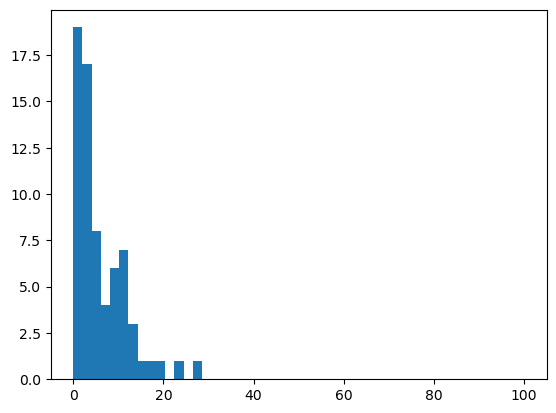

In [696]:
hist_true_1, os = PyPlot.hist(comb_pars_true[:,1], bins = LinRange(0.0, 100, 50));

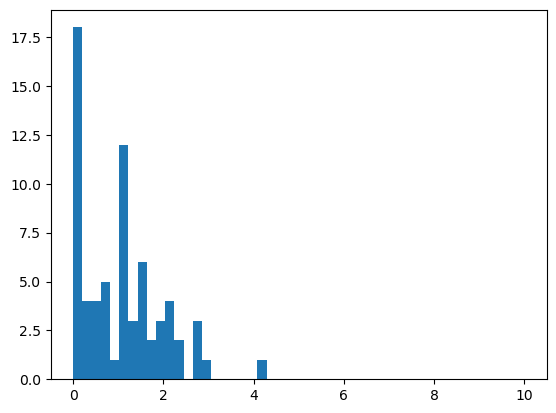

In [697]:
hist_true_2, os = PyPlot.hist(comb_pars_true[:,2], bins = LinRange(0.0, 10.0, 50));

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [700]:
av_ab_0_tr = median(comb_pars_true[:,1]); av_ab_1_tr = median(filter(x->x>0.01,comb_pars_true[:,2]));
print("Mean Lsq values: ", av_ab_0_tr, "\t", av_ab_1_tr, "\n")
print("True values: \t ", 10^true_par[1]*10^true_par[3], "\t", true_par_2[2]+true_par_2[4], "\n")

Mean Lsq values: 3.690003750673531	1.1707854220227505
True values: 	 3.981071705534973	1.000001


In [577]:
function new_distance(flat_lin_1::Array{Float64,1}, flat_lin_2::Array{Float64,1})
    # make the lineages of the correct form again.
    lin_1 = make_2d(flat_lin_1[:]); lin_2 = make_2d(flat_lin_2[:]);
    
    # now let's get the histograms for each set of parameters in this distance function.
    comb_pars_1 = [];
    for i in 1:length(v0_n0_th[1])
        v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
        c_0 = n0/v0; # define the initial conc.
        m(t,ab) = ((10.0 .^ab[1]*v0^(10.0 .^ab[2]-1))/(10.0 .^ab[2]*th)).*(exp.((10.0 .^ab[2]-1)*th*t).-exp.(-th*t)) .+ c_0.*exp.(-th*t);
        ab0 = [0.01, 1.0];
        c_data = lin_1[i];
        dfit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
        push!(comb_pars_1,dfit)
    end
    comb_pars_1 = convert(Array{Float64,2},transpose(hcat(comb_pars_1...)));
    
    # and for the second param set.
    comb_pars_2 = [];
    for i in 1:length(v0_n0_th[1])
        v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
        c_0 = n0/v0; # define the initial conc.
        m(t,ab) = ((10.0 .^ab[1]*v0^(10.0 .^ab[2]-1))/(10.0 .^ab[2]*th)).*(exp.((10.0 .^ab[2]-1)*th*t).-exp.(-th*t)) .+ c_0.*exp.(-th*t);        ab0 = [5.0, 1.0];
        ab0 = [0.01, 1.0];
        c_data = lin_2[i];
        dfit = 10 .^curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
        push!(comb_pars_2,dfit)
    end
    comb_pars_2 = convert(Array{Float64,2},transpose(hcat(comb_pars_2...)));
    
    # set the bins
    bins_a0b0 = LinRange(0.0, 100, 50);
    bins_a1b1 = LinRange(0.0, 10.0, 50); 
    
    # create the distributions
    dist_1_a0b0 = normalize(fit(Histogram, comb_pars_1[:,1], bins_a0b0), mode=:probability).weights;
    dist_1_a1b1 = normalize(fit(Histogram, comb_pars_1[:,2], bins_a1b1), mode=:probability).weights;
    dist_2_a0b0 = normalize(fit(Histogram, comb_pars_2[:,1], bins_a0b0), mode=:probability).weights;
    dist_2_a1b1 = normalize(fit(Histogram, comb_pars_2[:,2], bins_a1b1), mode=:probability).weights;
    
    # calculate the individual HDs
    d1 = hellinger(dist_1_a0b0, dist_2_a0b0); d2 = hellinger(dist_1_a1b1, dist_2_a1b1)
    
    # return the product of these distances.
    return d1*d2   
end

new_distance (generic function with 1 method)

In [578]:
@time new_distance(vcat(simulator_function_conc(true_par)...),vcat(simulator_function_conc(true_par)...))

  1.134664 seconds (1.55 M allocations: 94.850 MiB, 3.65% gc time)


0.04520683214484285

In [579]:
sum([new_distance(vcat(simulator_function_conc(true_par)...),vcat(simulator_function_conc(true_par)...)) for i in 1:100])/100.0

0.050722717450487176

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.15
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.125
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.1
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 467/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.075
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 185/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 384/2000 particles.
└ @ GpABC

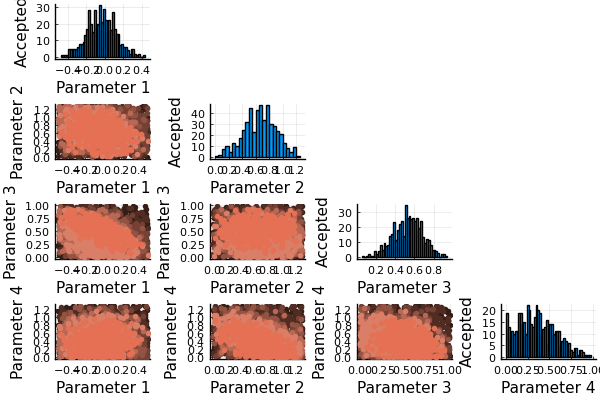

In [330]:
n_particles = 500;
threshold_schedule = [0.5, 0.25, 0.15, 0.125, 0.1, 0.075, 0.05];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(form_expt,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [331]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 -0.040126339397991984
  0.668469204992153
  0.5374605262139904
  0.3417393056085962

In [332]:
true_par

4-element Array{Float64,1}:
 0.1
 1.0e-6
 0.5
 0.8

## Repeat inference

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.15
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 412/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.125
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 466/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.1
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 285/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.075
└ @ GpABC

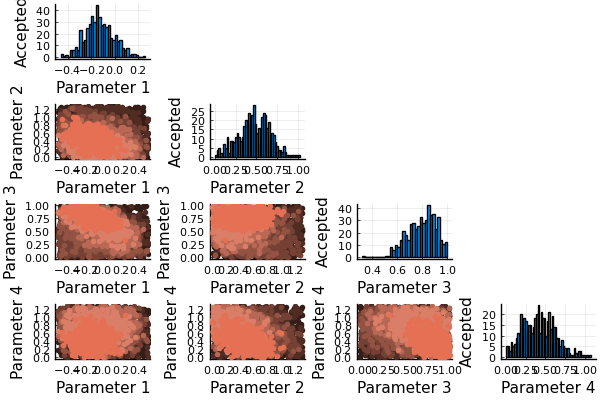

In [701]:
n_particles = 500;
threshold_schedule = [0.5, 0.25, 0.15, 0.125, 0.1, 0.075, 0.05];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(form_expt,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

In [702]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 -0.1373597119388429
  0.46583111830881574
  0.8088095013969063
  0.4161881396688939

In [703]:
true_par

4-element Array{Float64,1}:
 0.1
 1.0e-6
 0.5
 1.0

In [704]:
n_particles = 500;
threshold_schedule = [0.5, 0.25, 0.15, 0.125, 0.1, 0.075, 0.05];

priors = [Uniform(-0.5, 0.5), Uniform(0.0, 1.3), Uniform(0.0, 1.0),
          Uniform(0.0, 1.3)];

sim_abcsmc_res_conc_3 = SimulatedABCSMC(form_expt,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3, population_colors=population_colors)

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.15
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.125
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 455/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.1
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 321/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.075
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 145/1000 particles.
└ @ GpABC

LoadError: SingularException(2)

In [705]:
pars_conc_3 = [median(sim_abcsmc_res_conc_3.population[end][:,i]) for i in 1:4]

LoadError: UndefVarError: sim_abcsmc_res_conc_3 not defined

In [706]:
true_par

4-element Array{Float64,1}:
 0.1
 1.0e-6
 0.5
 1.0

**So it seems that one cannot use the Lsq procedure to infer parameters of the full stochastic model accurately, however reassuringly near correct values of $\alpha_0\beta_0$ and $\alpha_1+\beta_1$ are returned.**

**Importantly, this means that we can reduce the inference procedure in future to that over 2 parameters rather than 4.**

# Not relevant below

In [677]:
comb_pars_2 = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [5.0, 1.0];
    c_data = expt_ssa_conc_2[i];
    fit = curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars_2,fit)
end
comb_pars_2 = convert(Array{Float64,2},transpose(hcat(comb_pars_2...)));

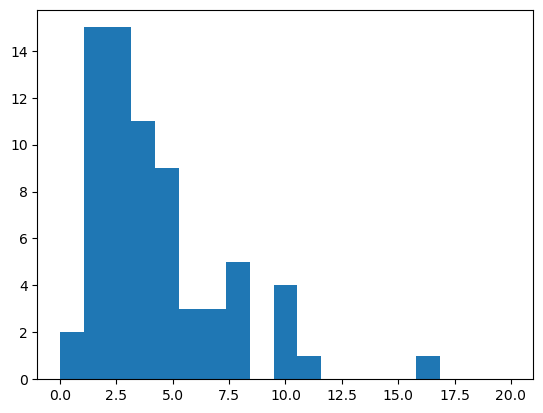

In [678]:
PyPlot.hist(comb_pars_2[:,1], bins = LinRange(0.0, 20, 20));

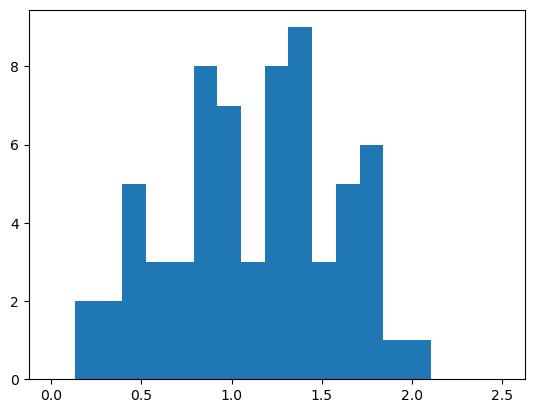

In [679]:
PyPlot.hist(comb_pars_2[:,2], bins = LinRange(0.0, 2.5, 20));

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [680]:
av_ab_0_2 = median(comb_pars_2[:,1]); av_ab_1_2 = median(comb_pars_2[:,2]);
print("Mean Lsq values: ", av_ab_0_2, "\t", av_ab_1_2, "\n")
print("True values: \t ", 10^true_par_2[1]*10^true_par_2[3], "\t", true_par_2[2]+true_par_2[4], "\n")

Mean Lsq values: 3.401080607291393	1.12507859518077
True values: 	 3.981071705534973	1.000001


In [681]:
comb_pars = [];
for i in 1:length(v0_n0_th[1])
    v0 = v0_n0_th[1][i][1]; n0 = v0_n0_th[1][i][2]; th = v0_n0_th[1][i][3];
    c_0 = n0/v0; # define the initial conc.
    m(t,ab) = ((ab[1]*v0^(ab[2]-1))/(ab[2]*th))*(exp.((ab[2]-1)*th*t)-exp.(-th*t)) + c_0*exp.(-th*t);
    ab0 = [1.0, 1.0];
    c_data = expt_ssa_conc[i];
    fit = curve_fit(m, LinRange(1,length(c_data), length(c_data)), c_data, ab0).param
    push!(comb_pars,fit)
end
comb_pars = convert(Array{Float64,2},transpose(hcat(comb_pars...)));

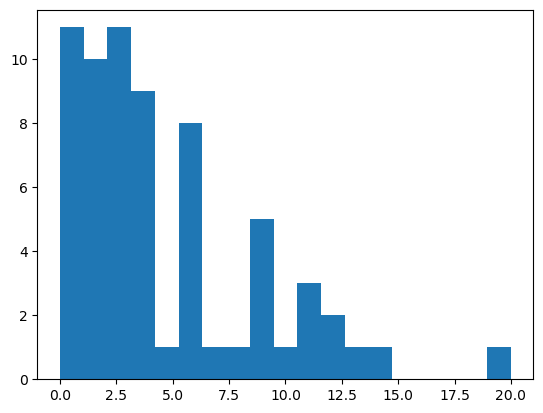

In [682]:
PyPlot.hist(comb_pars[:,1], bins = LinRange(0.0, 20, 20));

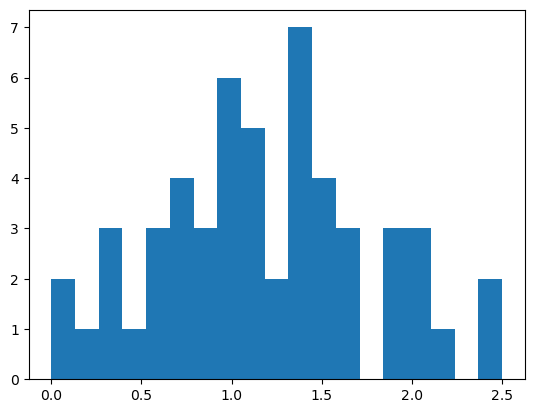

In [683]:
PyPlot.hist(comb_pars[:,2], bins = LinRange(0.0, 2.5, 20));

Let's compare the true values of $\alpha_0 \beta_0$ and $\alpha_1+\beta_1$ to the mean values over all least square fitting.

In [684]:
av_ab_0 = median(comb_pars[:,1]); av_ab_1 = median(comb_pars[:,2]);
print("Mean Lsq values: ", av_ab_0, "\t", av_ab_1, "\n")
print("True values: \t ", 10^true_par[1]*10^true_par[3], "\t", true_par[2]+true_par[4], "\n")

Mean Lsq values: 3.4212779054960865	1.0889881247363613
True values: 	 3.981071705534973	1.000001
